In [1]:
from pathlib import Path
import sys
import os

root = Path.cwd().parent
sys.path.append(str(root))

In [2]:
import re

def clean_text(text: str) -> str:
    """A robust function to remove problematic characters."""
    # This removes most non-printable and weird characters
    text = text.encode("utf-8", "ignore").decode("utf-8")
    # Optional: Remove any character that is not a standard ASCII character
    # This is more aggressive but very effective for English text.
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return text.strip()

In [3]:
import os

from langchain_openai.embeddings import OpenAIEmbeddings
from proptimize.schemas import EmbeddedExample, EmbeddedDataset
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()


model = OpenAIEmbeddings(
            base_url=f'http://localhost:{os.getenv("EMBEDD_PORT", "8001")}/v1',
            api_key=os.getenv("EMBEDD_API_KEY", "prompt-paper"),
            model=os.getenv("EMBEDD_MODEL"),
            tiktoken_enabled=True,
            # api_key=os.getenv
        )
print("Using embedding model:", model)

def generate_embeddings(input_dataset, batch_size):

    embedded_examples = []

    for i in tqdm(
        range(0, len(input_dataset.examples), batch_size), 
        desc="Generating embeddings", 
        ncols=75
    ):
        batch = input_dataset.examples[i : i + batch_size]
        texts = [ex.text.replace("\n", " ") for ex in batch if len (ex.text.strip()) < 700]
        
        texts = [clean_text(text) for text in texts]
        

        embeddings = model.embed_documents(texts)

        for ex, emb in zip(batch, embeddings):
            embedded_examples.append(
                EmbeddedExample(
                    example_id=ex.example_id,
                    text=ex.text,
                    embedding=emb
                )
            )

    return EmbeddedDataset(
            examples=embedded_examples,
            task_type=input_dataset.task_type
        )
    

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using embedding model: client=<openai.resources.embeddings.Embeddings object at 0x779909613980> async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x7797474d2780> model='Qwen/Qwen3-Embedding-4B' dimensions=None deployment='text-embedding-ada-002' openai_api_version=None openai_api_base='http://localhost:8001/v1' openai_api_type=None openai_proxy=None embedding_ctx_length=8191 openai_api_key=SecretStr('**********') openai_organization=None allowed_special=None disallowed_special=None chunk_size=1000 max_retries=2 request_timeout=None headers=None tiktoken_enabled=True tiktoken_model_name=None show_progress_bar=False model_kwargs={} skip_empty=False default_headers=None default_query=None retry_min_seconds=4 retry_max_seconds=20 http_client=None http_async_client=None check_embedding_ctx_length=True


In [4]:
from proptimize.data_manager import DataManager
from proptimize.schemas import EmbeddedExample, EmbeddedDataset

# Create a DataManager instance for the NER task
data_manager = DataManager(task="financial_ner", base_dir=root / "tasks")
input_dataset = data_manager.load_input_dataset("Financial-NER-NLP_train.jsonl")

embedding_dataset = generate_embeddings(input_dataset, batch_size=64)

Generating embeddings: 100%|█████████████| 113/113 [00:09<00:00, 12.01it/s]


In [5]:
import numpy as np

embeddings = np.array([example.embedding for example in embedding_dataset.examples])
embeddings = np.vstack(embeddings)

In [6]:
from sklearn.manifold import TSNE

SEED = 42

tsne = TSNE(n_components=2, random_state=SEED)

embeddings_tsne = tsne.fit_transform(embeddings)

In [7]:
import warnings
import umap

warnings.filterwarnings('ignore')

umap_reducer = umap.UMAP(n_components=30, random_state=SEED)

embeddings_umap = umap_reducer.fit_transform(embeddings)

### HDBSCAN Parameters

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#

- `min_cluster_size` should be set to the smallest size grouping one wish to consider a cluster.

- `min_samples` if unspecified follows `min_cluster_size`, but if set it essentially provide a measure of how conservative one want the clustering to be.

- `cluster_selection_epsilon` is nice because it allows me to set a small `min_cluster_size` becasue groups of few points are important. The param sets a threshold so that clusters below it are not split up any further.

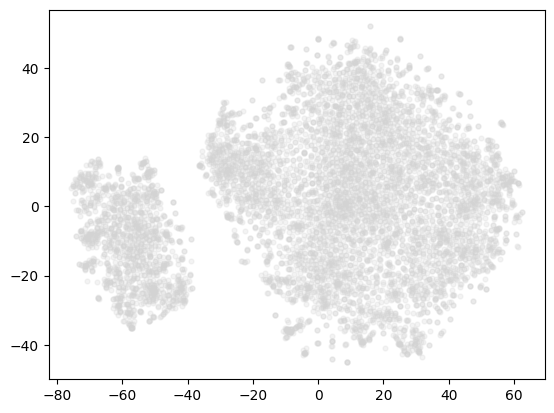

In [8]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c="lightgrey", alpha=0.25, s=12)

Number of clusters found: 16
6888
0.3885017421602787


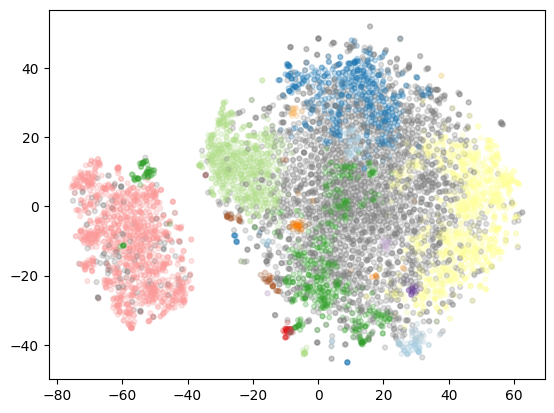

In [24]:
import hdbscan
import seaborn as sns

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10, 
    min_samples=10,
    cluster_selection_epsilon=0.30,
    cluster_selection_persistence=.7,
    max_cluster_size=200,
    cluster_selection_method='eom',
).fit(embeddings_umap)
color_palette = sns.color_palette("Paired", n_colors=len(set(clusterer.labels_))) 
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]


print("Number of clusters found:", len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0))
print(len(embeddings_umap))
print(clusterer.labels_.tolist().count(-1) / len(clusterer.labels_))


plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_member_colors, alpha=0.25, s=12)

In [10]:
import plotly.express as px

fig = px.scatter(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    color=clusterer.labels_.astype(str),
)

fig.show()